In [1]:
import numpy as np
import pandas as pd
import tempfile
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import yaml

import common

from fv3fit.train_microphysics import TrainConfig

In [2]:
base = "zc-emu-monthly-normfix-m{init}-seed3-30d-v1"

In [3]:
url = common.get_group_url("zc-emu-monthly-normfix-m{init}-seed3-30d-v1-offline".format(init="01"))

No state saved for online runs.  Check offline instead.

In [4]:
gscond_model_path = "gs://vcm-ml-experiments/microphysics-emulation/2023-02-10/zc-train-gscond-normfix-seed3-v1"
classifier_path = "gs://vcm-ml-experiments/microphysics-emulation/2022-12-16/zc-train-gscond-classify-seed5-v2"
model = tf.keras.models.load_model(f"{gscond_model_path}/model.tf")
classifier = tf.keras.models.load_model(f"{classifier_path}/model.tf")

In [5]:
def load_model_config(path):
    with tempfile.TemporaryDirectory() as tmpdir:
        dst = f"{tmpdir}/config.yaml"
        !gsutil cp {path}/config.yaml {dst}
        with open(dst, "r") as f:
            d = yaml.safe_load(f)
            d.pop("seed")
            d.pop("loss")
        return TrainConfig.from_dict(d)

cfg = load_model_config(gscond_model_path)
cls_cfg = load_model_config(classifier_path)




Updates are available for some Google Cloud CLI components.  To install them,
please run:
  $ gcloud components update

Copying gs://vcm-ml-experiments/microphysics-emulation/2023-02-10/zc-train-gscond-normfix-seed3-v1/config.yaml...
/ [1 files][  2.9 KiB/  2.9 KiB]                                                
Operation completed over 1 objects/2.9 KiB.                                      
Copying gs://vcm-ml-experiments/microphysics-emulation/2022-12-16/zc-train-gscond-classify-seed5-v2/config.yaml...
/ [1 files][  2.4 KiB/  2.4 KiB]                                                
Operation completed over 1 objects/2.4 KiB.                                      


In [32]:
test = cfg.open_dataset(cfg.test_url, None, required_variables=cfg.model_variables | {"cloud_water_mixing_ratio_after_gscond"})
test = cfg.prepare_flat_data(test)

In [33]:
profiles = next(iter(test.shuffle(180_000).batch(100_000)))


In [136]:

transform = cfg.build_transform(profiles)

In [152]:
target = transform.backward(transform.forward(profiles))

In [151]:
predictions = model.predict(profiles, batch_size=512)

/home/andrep/miniconda3/envs/fv3net/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['specific_humidity_after_gscond', 'cloud_water_mixing_ratio_after_gscond'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


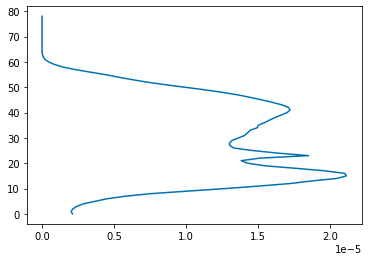

In [71]:
cin = profiles["cloud_water_mixing_ratio_input"]
cout = target["cloud_water_mixing_ratio_after_gscond"]
plt.plot(cout.numpy().mean(axis=0), range(79))

In [72]:
state_thresh = 1e-15
tend_thresh = 1e-15

tend = (cout - cin) / 900
some_cloud_out = tf.abs(cout) > state_thresh
negative_tend = tend < -tend_thresh


In [73]:
some_cloud_out.numpy().sum(axis=0)

array([10354, 10055, 10586, 11564, 12851, 14740, 17060, 20817, 25702,
       30542, 32667, 30623, 26584, 24199, 23539, 22846, 22320, 21283,
       19959, 18931, 18216, 17911, 18131, 18853, 18474, 18058, 17674,
       17578, 17691, 17863, 18227, 18627, 19146, 19578, 19892, 20086,
       20378, 20659, 20977, 21549, 22240, 22789, 23489, 24261, 24990,
       25750, 26386, 27105, 27513, 27586, 27242, 26384, 25271, 23887,
       22409, 21600, 19999, 19199, 18492, 17834, 16672, 14214, 10266,
        4243,   770,    21,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0])

In [74]:

(negative_tend & ~some_cloud_out).numpy().sum(axis=0)

array([65779, 66271, 66000, 65345, 64361, 62766, 60690, 57144, 52372,
       47507, 45340, 47346, 51164, 53244, 52879, 51577, 48506, 45840,
       43461, 40847, 37607, 34007, 30419, 27037, 25575, 24725, 23912,
       22572, 21085, 20303, 19734, 19331, 18886, 18555, 18273, 18070,
       17764, 17505, 17336, 17251, 17049, 17152, 17429, 17510, 17652,
       17877, 18086, 18065, 18124, 18059, 17694, 17176, 16545, 15928,
       15288, 13488, 12394, 10443,  9263,  8445,  7793,  7247,  6548,
        6101,  2870,   488,     1,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0])

In [177]:
def plot_hexbin_dist(T, q, title, ax, q_condition=None, vmax=3e4, ylabel="dq [kg/kg/s]", xlabel="Temperature [K]", **kwargs):
    
    if q_condition=="neg":
        condition = q < 0
    elif q_condition=="pos":
        condition = q > 0
    else:
        condition = q != 0
            
    T = T[condition]
    q = q[condition]
    
    
    coll = ax.hexbin(abs(T), abs(np.array(q)), yscale="log", cmap="Greens", gridsize=150, bins="log", vmin=1, vmax=vmax, **kwargs)
    plt.colorbar(coll, ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

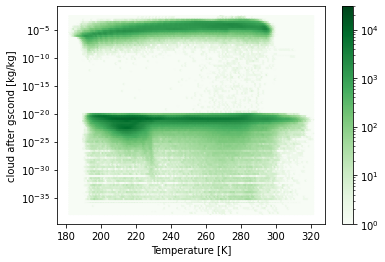

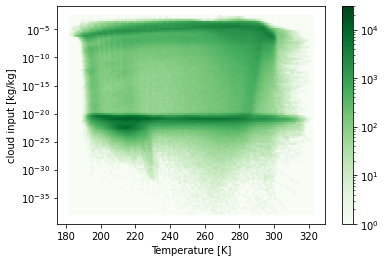

In [75]:
fig, ax = plt.subplots()
plot_hexbin_dist(target["air_temperature_input"], cout, "", ax, ylabel="cloud after gscond [kg/kg]")

fig, ax = plt.subplots()
plot_hexbin_dist(target["air_temperature_input"], cin, "", ax, ylabel="cloud input [kg/kg]")

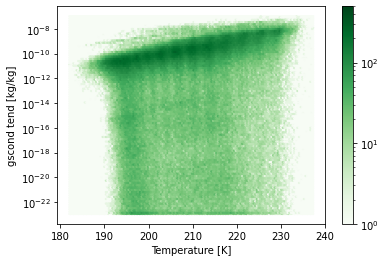

In [76]:
fig, ax = plt.subplots()
plot_hexbin_dist(target["air_temperature_input"][..., -29:-11].numpy().flatten(), tend[..., -29:-11].numpy().flatten(), "", ax, ylabel="gscond tend [kg/kg]", vmax=5e2)

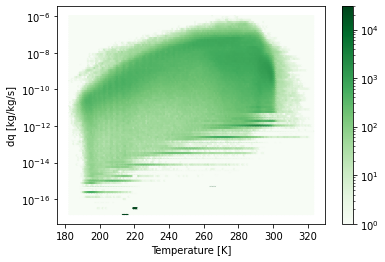

In [12]:
fig, ax = plt.subplots()
plot_hexbin_dist(target["air_temperature_input"], target["humidity_gscond_difference"]/900, "", ax)

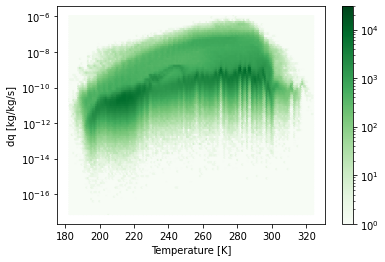

In [13]:
fig, ax = plt.subplots()
plot_hexbin_dist(target["air_temperature_input"], predictions["humidity_gscond_difference"]/900, "", ax)

In [77]:
POSITIVE_TENDENCY = "positive_tendency"
ZERO_TENDENCY = "zero_tendency"
ZERO_CLOUD = "zero_cloud"
NEGATIVE_TENDENCY = "negative_tendency"
NONTRIVIAL_TENDENCY = "nontrivial_tendency"

# this constant is reused elswhere so is effectively public api
CLASS_NAMES = {
    POSITIVE_TENDENCY,
    ZERO_TENDENCY,
    ZERO_CLOUD,
    NEGATIVE_TENDENCY,
}

def _get_classify_output(logit_classes, one_hot_axis=1):
    names = sorted(CLASS_NAMES)
    one_hot = logit_classes == np.max(logit_classes, axis=one_hot_axis, keepdims=True)
    d = {name: np.take(one_hot, i, one_hot_axis) for i, name in enumerate(names)}
    d["nontrivial_tendency"] = d[POSITIVE_TENDENCY] | d[NEGATIVE_TENDENCY]
    return d

def classify(cloud_in, cloud_out, timestep, math=tf.math):
    state_thresh = 1e-15
    tend_thresh = 1e-15

    tend = (cloud_out - cloud_in) / timestep
    some_cloud_out = math.abs(cloud_out) > state_thresh
    negative_tend = tend < -tend_thresh

    return {
        POSITIVE_TENDENCY: tend > tend_thresh,
        ZERO_TENDENCY: math.abs(tend) <= tend_thresh,
        ZERO_CLOUD: negative_tend & ~some_cloud_out,
        NEGATIVE_TENDENCY: negative_tend & some_cloud_out,
    }

In [78]:
cl_pred = classifier.predict(profiles, batch_size=512)


/home/andrep/miniconda3/envs/fv3net/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['specific_humidity_after_gscond', 'cloud_water_mixing_ratio_after_gscond'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [79]:

classified = _get_classify_output(cl_pred["gscond_classes"], one_hot_axis=-1)

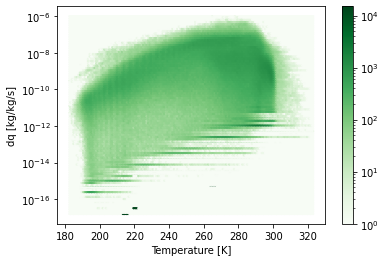

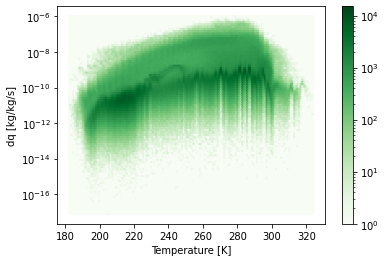

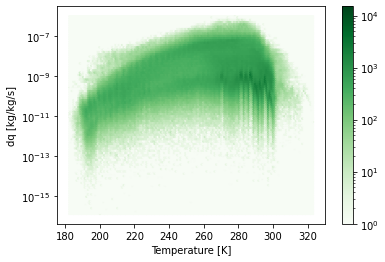

In [17]:
dc = -1 * predictions["humidity_gscond_difference"]/900
dc_masked = dc.copy()
dc_masked[classified["zero_tendency"]] = 0.0

fig, ax = plt.subplots()
plot_hexbin_dist(target["air_temperature_input"], target["humidity_gscond_difference"]/900, "", ax, vmax=1.5e4)

fig, ax = plt.subplots()
plot_hexbin_dist(target["air_temperature_input"], dc, "", ax, vmax=1.5e4)

fig, ax = plt.subplots()
plot_hexbin_dist(target["air_temperature_input"], dc_masked, "", ax, vmax=1.5e4)

## Arctic stratosphere only
compare target vs. what the predicted fractions are

In [80]:
arctic_test = cfg.open_dataset(cfg.train_url, nfiles=None, required_variables=set(cfg.model_variables | {"latitude", "cloud_water_mixing_ratio_after_gscond"}))
arctic_test = cfg.prepare_flat_data(arctic_test)

In [81]:
def limit_arc(d):
    arc_out = {}
    mask = np.squeeze(np.rad2deg(d["latitude"]) > 60)
    for k, v in d.items():
        arc_out[k] = v.numpy()[mask]

    return arc_out


combined_arc = {}
for b in iter(arctic_test.shuffle(150_000).batch(10_000)):
    limited = limit_arc(b)
    for k, v in limited.items():
        prev_b = combined_arc.get(k, [])
        combined = np.concatenate(prev_b + [v], axis=0)
        combined_arc[k] = [combined]
    
    if combined.shape[0] > 100_000:
        break

combined_arc = {k: v[0] for k, v in combined_arc.items()}


In [82]:
def limit_non_arc(d):
    out = {}
    lat_deg = np.squeeze(np.rad2deg(d["latitude"]))
    mask =  np.logical_and(lat_deg <= 60, lat_deg >= -60)
    for k, v in d.items():
        out[k] = v.numpy()[mask]

    return out

combined_non_arc = {}
for b in iter(arctic_test.shuffle(150_000).batch(10_000)):
    limited = limit_non_arc(b)
    for k, v in limited.items():
        prev_b = combined_non_arc.get(k, [])
        combined = np.concatenate(prev_b + [v], axis=0)
        combined_non_arc[k] = [combined]
    
    if combined.shape[0] > 100_000:
        break

combined_non_arc = {k: v[0] for k, v in combined_non_arc.items()}

In [83]:
def get_target_prediction(model, transform, profiles):
    predict = model.predict(profiles, batch_size=512)
    target = transform.backward(transform.forward(profiles))
    return target, predict

In [137]:
arc_target, arc_gscond = get_target_prediction(model, transform, combined_arc)
_, arc_classified_ = get_target_prediction(classifier, transform, combined_arc)


In [138]:

arc_cl_target = classify(combined_arc["cloud_water_mixing_ratio_input"], combined_arc["cloud_water_mixing_ratio_after_gscond"], 900)
arc_classified = _get_classify_output(arc_classified_["gscond_classes"], one_hot_axis=-1)

In [139]:
tmp = {}
for k, v in arc_cl_target.items():
    if hasattr(v, "numpy"):
        tmp[k] = v.numpy()
    else:
        tmp[k] = v
arc_cl_target = tmp

In [108]:
def calc_precision(target, prediction):
    true_positive = np.logical_and(target[prediction], prediction[prediction]).sum()
    false_positive = np.logical_xor(target[prediction], prediction[prediction]).sum()
    return true_positive / (true_positive + false_positive)

def calc_recall(target, prediction):
    true_positive = np.logical_and(target[prediction], prediction[prediction]).sum()
    not_pred = np.logical_not(prediction)
    false_negative = np.logical_xor(target[not_pred], prediction[not_pred]).sum()
    return true_positive / (true_positive + false_negative)


In [112]:
def get_classifier_metrics(target_classes, pred_classes):
    class_metrics = {}
    for k in target_classes.keys():
        pred_class = pred_classes[k][-29:-11]
        print(k)
        targ_class = target_classes[k][-29:-11]
        targ_perc = targ_class.sum() / targ_class.size
        pred_perc = pred_class.sum() / pred_class.size

        precision = calc_precision(targ_class, pred_class)
        recall = calc_recall(targ_class, pred_class)
        acc = skm.accuracy_score(targ_class.flatten(), pred_class.flatten())
        class_metrics[k] = np.array((targ_perc, pred_perc, precision, recall, acc))

    class_metrics = pd.DataFrame(
        class_metrics,
        index=["observed %", "predicted %", "precision", "recall", "accuracy"]
    ).transpose().round(2)

    return class_metrics

In [140]:
get_classifier_metrics(arc_cl_target, arc_classified)

positive_tendency
zero_tendency
zero_cloud
negative_tendency


,observed %,predicted %,precision,recall,accuracy
positive_tendency,0.17,0.18,0.87,0.96,0.97
zero_tendency,0.62,0.63,0.94,0.96,0.94
zero_cloud,0.20,0.17,0.96,0.82,0.96
negative_tendency,0.02,0.02,0.66,0.72,0.99


In [141]:
def get_pred_metrics(target, prediction, axis=None):
    diff = (target - prediction)
    mse = np.nanmean(diff**2, axis=axis)
    skill = 1 - (mse/(np.nanmean(target**2, axis=axis)))
    bias = np.mean(diff, axis=axis)
    return np.sqrt(mse), bias, skill


def plot_classifier_adjusted(target, prediction, pred_classes, strato=False, vmax=1.5e4):
    target_dq = target["humidity_gscond_difference"].numpy()/900
    pred_dq = prediction["humidity_gscond_difference"]/900
    T_in = target["air_temperature_input"]
    cloud_in = target["cloud_water_mixing_ratio_input"]
    zero_tend = pred_classes["zero_tendency"]
    zero_cloud = pred_classes["zero_cloud"]

    if strato:
        target_dq = target_dq[..., -29:-11]
        pred_dq = pred_dq[..., -29:-11]
        T_in = T_in[..., -29:-11]
        cloud_in = cloud_in[..., -29:-11]
        zero_tend = zero_tend[..., -29:-11]
        zero_cloud = zero_cloud[..., -29:-11]

    pred_dq_ztend = pred_dq.copy()
    pred_dq_ztend[zero_tend] = 0.0

    pred_dq_zcloud = pred_dq.copy()
    pred_dq_zcloud[zero_cloud] = cloud_in[zero_cloud]/900

    pred_dq_ztend_zcloud = pred_dq.copy()
    pred_dq_ztend_zcloud[zero_tend] = 0.0
    pred_dq_ztend_zcloud[zero_cloud] = cloud_in[zero_cloud]/900

    figsize = (6,4)
    dpi = 120
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    plot_hexbin_dist(T_in, target_dq, "Target dq distribution", ax, vmax=vmax)
    plt.xlim(180, 235)
    plt.ylim(1e-17, 1e-7)
    plt.show()

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    plot_hexbin_dist(T_in, pred_dq, "Predicted dq distribution", ax, vmax=vmax)
    plt.xlim(180, 235)
    plt.ylim(1e-17, 1e-7)
    plt.show()
    print("rmse={:1.2e}, bias={:1.2e}, skill={:1.2f}".format(*get_pred_metrics(target_dq, pred_dq)))

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    plot_hexbin_dist(T_in, pred_dq_ztend, "Predicted dq distribution (zero_tend)", ax, vmax=vmax)
    plt.xlim(180, 235)
    plt.ylim(1e-17, 1e-7)
    plt.show()
    print("rmse={:1.2e}, bias={:1.2e}, skill={:1.2f}".format(*get_pred_metrics(target_dq, pred_dq_ztend)))

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    plot_hexbin_dist(T_in, pred_dq_zcloud, "Predicted dq distribution  (zero_cloud)", ax, vmax=vmax)
    plt.xlim(180, 235)
    plt.ylim(1e-17, 1e-7)
    plt.show()
    print("rmse={:1.2e}, bias={:1.2e}, skill={:1.2f}".format(*get_pred_metrics(target_dq, pred_dq_zcloud)))

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    plot_hexbin_dist(T_in, pred_dq_ztend_zcloud, "Predicted dq distribution  (zero_tend, zero_cloud)", ax, vmax=vmax)
    plt.xlim(180, 235)
    plt.ylim(1e-17, 1e-7)
    plt.show()
    print("rmse={:1.2e}, bias={:1.2e}, skill={:1.2f}".format(*get_pred_metrics(target_dq, pred_dq_ztend_zcloud)))

    

In [142]:
arc_target["cloud_water_mixing_ratio_input"] = combined_arc["cloud_water_mixing_ratio_input"]

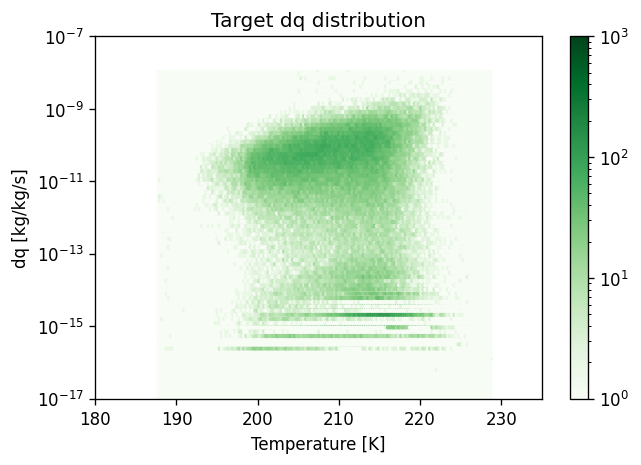

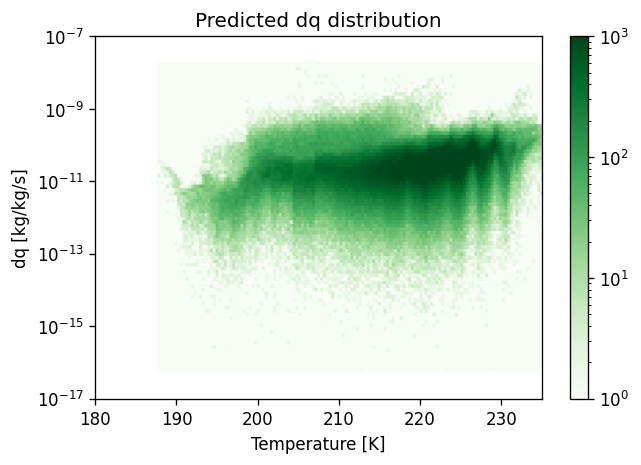

rmse=6.08e-11, bias=-4.10e-12, skill=0.19


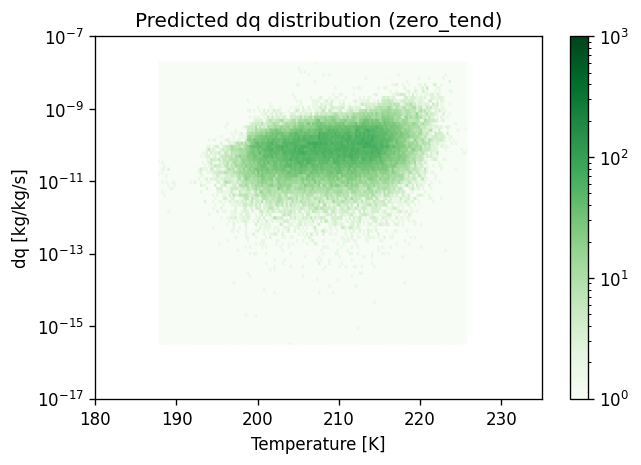

rmse=2.85e-11, bias=-6.37e-14, skill=0.82


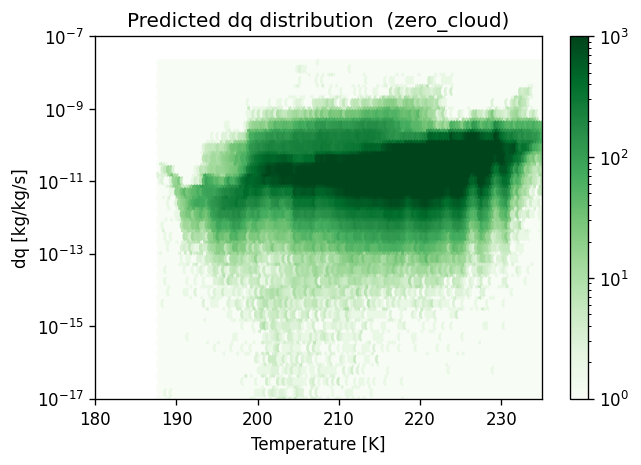

rmse=5.98e-11, bias=-3.94e-12, skill=0.22


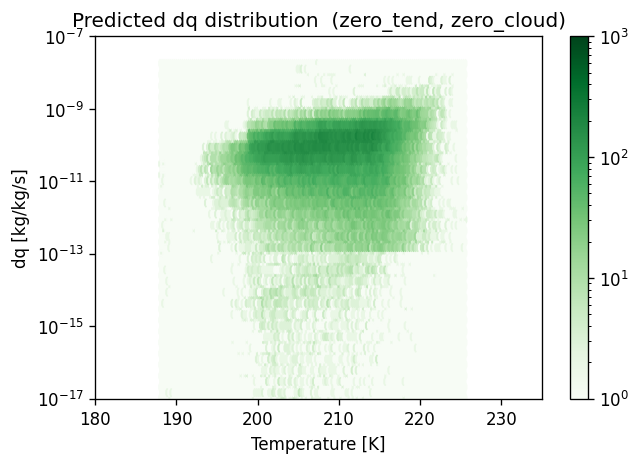

rmse=2.64e-11, bias=9.09e-14, skill=0.85


In [143]:
plot_classifier_adjusted(arc_target, arc_gscond, arc_classified, strato=True, vmax=1e3)

## What about for non-polar regions?

In [144]:
non_arc_target, non_arc_gscond = get_target_prediction(model, transform, combined_non_arc)
non_arc_cl_target, non_arc_classified = get_target_prediction(classifier, transform, combined_non_arc)
non_arc_cl_target = classify(combined_non_arc["cloud_water_mixing_ratio_input"], combined_non_arc["cloud_water_mixing_ratio_after_gscond"], 900)
non_arc_classified = _get_classify_output(non_arc_classified["gscond_classes"], one_hot_axis=-1)
tmp = {}
for k, v in non_arc_cl_target.items():
    if hasattr(v, "numpy"):
        tmp[k] = v.numpy()
    else:
        tmp[k] = v
non_arc_cl_target = tmp

In [145]:
get_classifier_metrics(non_arc_cl_target, non_arc_classified)

positive_tendency
zero_tendency
zero_cloud
negative_tendency


,observed %,predicted %,precision,recall,accuracy
positive_tendency,0.13,0.13,0.98,0.97,0.99
zero_tendency,0.56,0.58,0.95,0.99,0.97
zero_cloud,0.27,0.26,0.98,0.91,0.97
negative_tendency,0.04,0.04,1.00,0.93,1.00


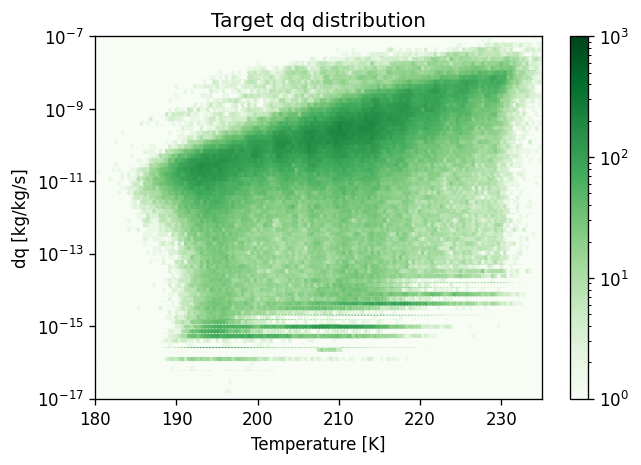

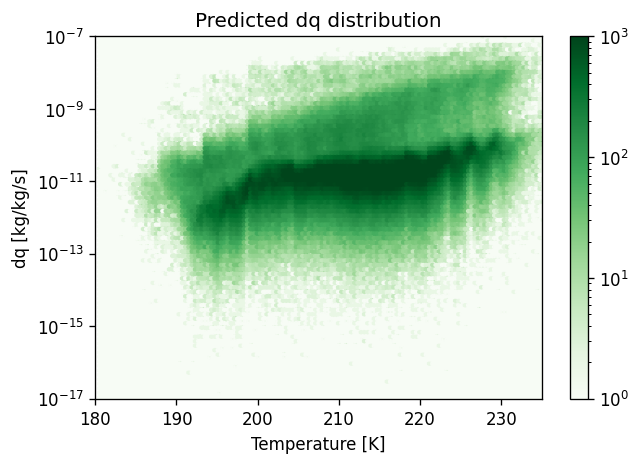

rmse=1.25e-10, bias=-9.84e-13, skill=0.99


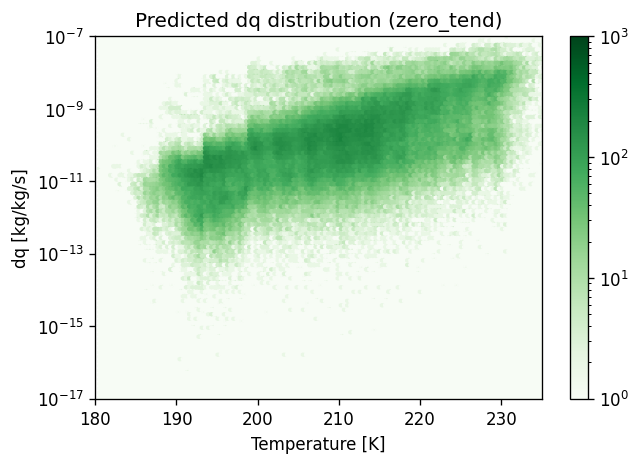

rmse=1.20e-10, bias=2.14e-12, skill=0.99


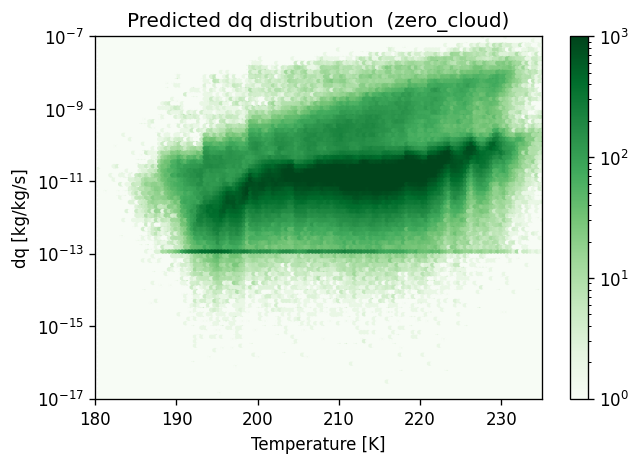

rmse=1.20e-10, bias=-8.38e-13, skill=0.99


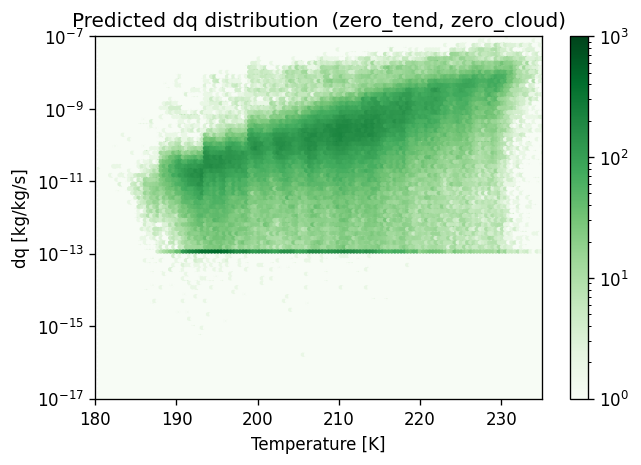

rmse=1.14e-10, bias=2.29e-12, skill=0.99


In [146]:
plot_classifier_adjusted(non_arc_target, non_arc_gscond, non_arc_classified, strato=True, vmax=1e3)

## Check the T-scaled distributions of raw gscond data

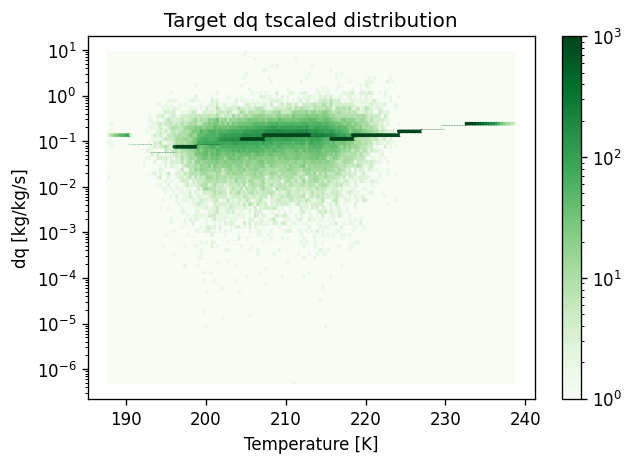

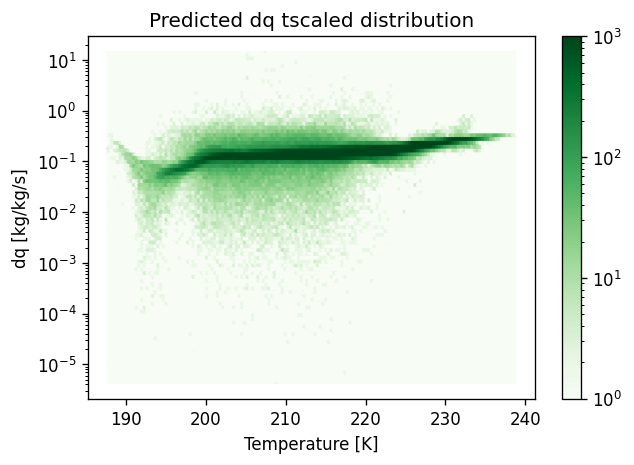

rmse=3.91e-02, bias=-2.42e-02, skill=0.93


In [147]:
fig, ax = plt.subplots(dpi=120)
T_in = combined_arc["air_temperature_input"][..., -29:-11]
dq_tscaled_targ = arc_target["humidity_gscond_difference_tscaled"][..., -29:-11]
dq_tscaled_pred = arc_gscond["humidity_gscond_difference_tscaled"][..., -29:-11]
plot_hexbin_dist(T_in, dq_tscaled_targ, "Target dq tscaled distribution", ax, vmax=1e3)
plt.show()

fig, ax = plt.subplots(dpi=120)
plot_hexbin_dist(T_in, dq_tscaled_pred, "Predicted dq tscaled distribution", ax, vmax=1e3)
plt.show()

print("rmse={:1.2e}, bias={:1.2e}, skill={:1.2f}".format(*get_pred_metrics(dq_tscaled_targ, dq_tscaled_pred)))

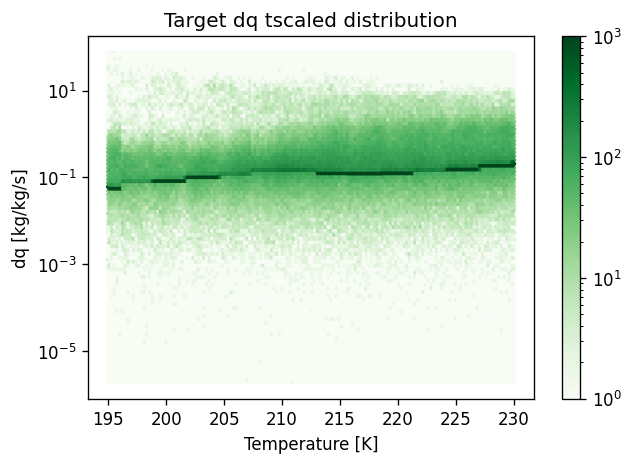

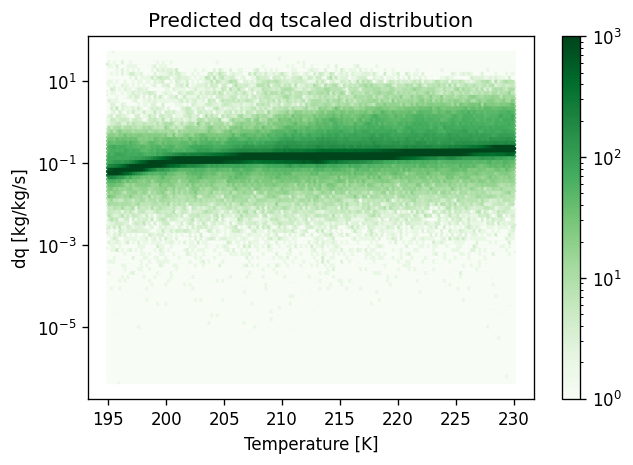

rmse=9.28e-02, bias=-1.92e-02, skill=0.96


In [148]:
fig, ax = plt.subplots(dpi=120)
T_in = combined_non_arc["air_temperature_input"]
T_mask = np.logical_and(T_in < 230, T_in > 195)
dq_tscaled_targ = non_arc_target["humidity_gscond_difference_tscaled"][T_mask]
dq_tscaled_pred = non_arc_gscond["humidity_gscond_difference_tscaled"][T_mask]
plot_hexbin_dist(T_in[T_mask], dq_tscaled_targ, "Target dq tscaled distribution", ax, vmax=1e3)
plt.show()

fig, ax = plt.subplots(dpi=120)
plot_hexbin_dist(T_in[T_mask], dq_tscaled_pred, "Predicted dq tscaled distribution", ax, vmax=1e3)
plt.show()

print("rmse={:1.2e}, bias={:1.2e}, skill={:1.2f}".format(*get_pred_metrics(dq_tscaled_targ, dq_tscaled_pred)))

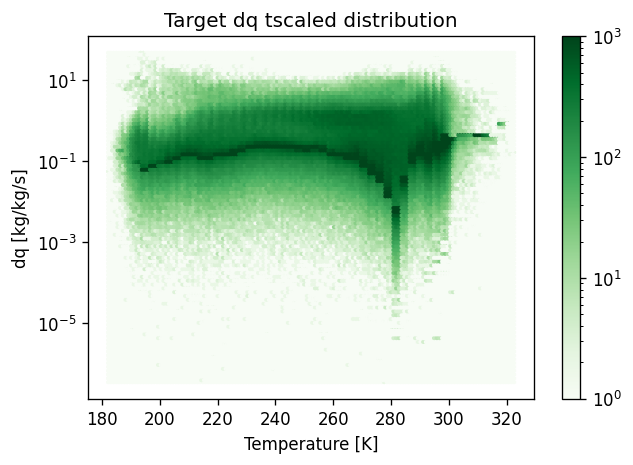

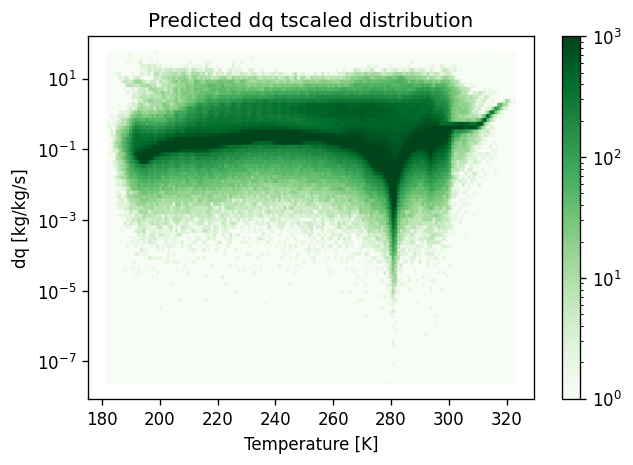

rmse=1.14e-01, bias=-1.33e-02, skill=0.96


In [153]:
fig, ax = plt.subplots(dpi=120)
T_in = profiles["air_temperature_input"]
dq_tscaled_targ = target["humidity_gscond_difference_tscaled"]
dq_tscaled_pred = predictions["humidity_gscond_difference_tscaled"]
plot_hexbin_dist(T_in, dq_tscaled_targ, "Target dq tscaled distribution", ax, vmax=1e3)
plt.show()



fig, ax = plt.subplots(dpi=120)
plot_hexbin_dist(T_in, dq_tscaled_pred, "Predicted dq tscaled distribution", ax, vmax=1e3)
plt.show()

print("rmse={:1.2e}, bias={:1.2e}, skill={:1.2f}".format(*get_pred_metrics(dq_tscaled_targ, dq_tscaled_pred)))

In [155]:
0.114**2

0.012996

## Zero cloud miss locations target vs pred dq

In [212]:
def plot_hist_comparison(data1, label1, data2, label2):

    bins = np.logspace(-15, -7, 50)
    plt.figure(dpi=120)
    plt.hist(
        abs(data1.flatten()),
        bins=bins,
        log=True,
        histtype="step",
        label=label1
    )
    plt.hist(
        abs(data2.flatten()),
        bins=bins,
        log=True,
        histtype="step",
        label=label2
    )
    plt.gca().set_xscale("log")
    plt.legend()

In [213]:
dq_targ = arc_target["humidity_gscond_difference"][..., -29:-11]/900
dq_pred = arc_gscond["humidity_gscond_difference"][..., -29:-11]/900
neg_targ_idx = dq_targ > 0

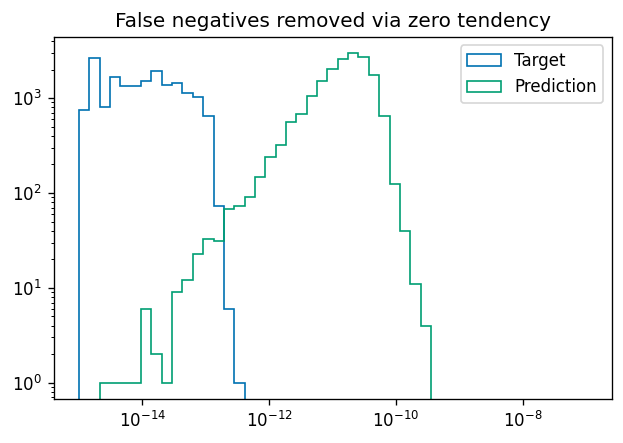

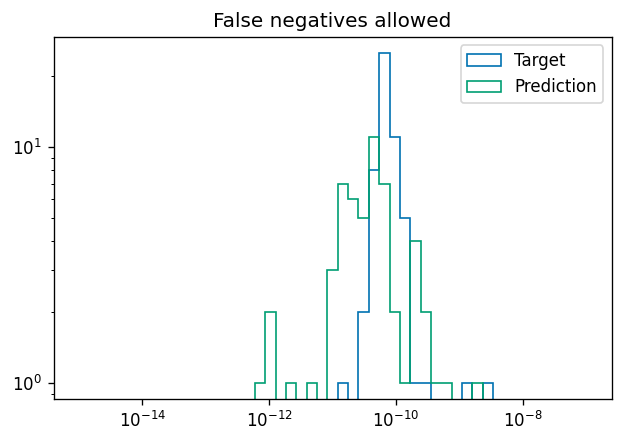

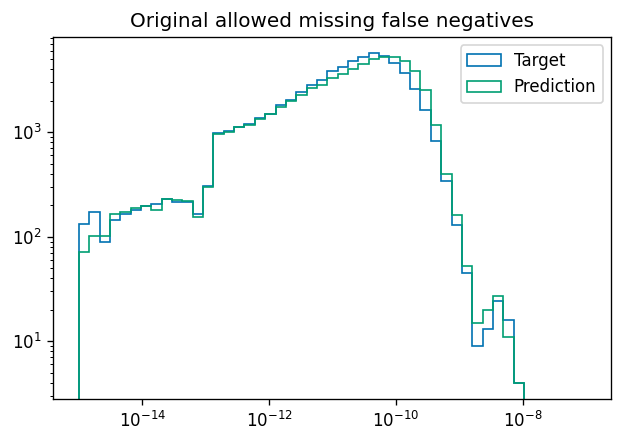

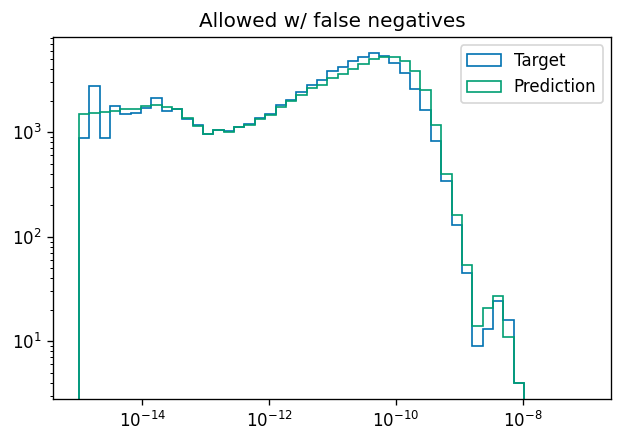

In [217]:
cloud_in = combined_arc["cloud_water_mixing_ratio_input"][..., -29:-11][neg_targ_idx]
nontrivial = arc_classified["nontrivial_tendency"][..., -29:-11][neg_targ_idx]
zero_cloud = arc_classified["zero_cloud"][..., -29:-11][neg_targ_idx]
zero_tend = arc_classified["zero_tendency"][..., -29:-11][neg_targ_idx]
zero_cloud_target = arc_cl_target["zero_cloud"][..., -29:-11][neg_targ_idx]

false_negatives =  np.logical_and(zero_cloud_target == True, zero_cloud == False)
removed =  zero_tend & false_negatives
allowed_fn = nontrivial & false_negatives
allowed =  zero_cloud | nontrivial
perfect_precision = allowed | false_negatives

adjusted = dq_pred[neg_targ_idx].copy()
adjusted[zero_tend] = 0.0
adjusted[zero_cloud] = cloud_in[zero_cloud]/900
adjusted_perfect_precision = dq_pred[neg_targ_idx].copy()
adjusted_perfect_precision[zero_tend] = 0.0
adjusted_perfect_precision[zero_cloud | false_negatives] = cloud_in[zero_cloud | false_negatives]/900

plot_hist_comparison(dq_targ[neg_targ_idx][removed].numpy(), "Target", dq_pred[neg_targ_idx][removed], "Prediction")
plt.title("False negatives removed via zero tendency")
plt.show()

plot_hist_comparison(dq_targ[neg_targ_idx][allowed_fn].numpy(), "Target", dq_pred[neg_targ_idx][allowed_fn], "Prediction")
plt.title("False negatives allowed")
plt.show()

plot_hist_comparison(dq_targ[neg_targ_idx][allowed].numpy(), "Target", adjusted[allowed], "Prediction")
plt.title("Original allowed missing false negatives")
plt.show()

plot_hist_comparison(dq_targ[neg_targ_idx][perfect_precision].numpy(), "Target", adjusted_perfect_precision[perfect_precision], "Prediction")
plt.title("Allowed w/ false negatives")
plt.show()


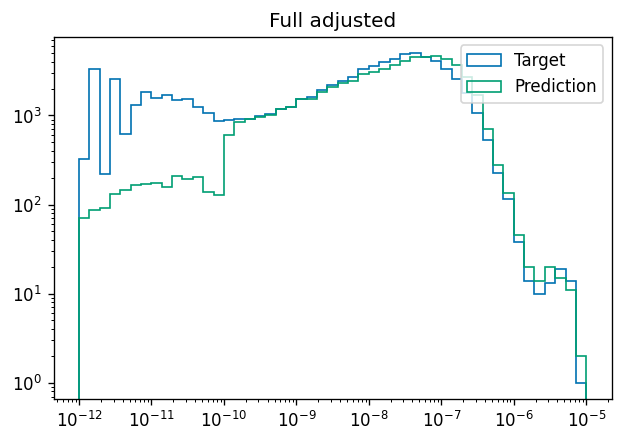

In [208]:

plot_hist_comparison(dq_targ[neg_targ_idx].numpy(), "Target", adjusted, "Prediction")
plt.title("Full adjusted")
plt.show()


# false negative + zero tendency = distribution components supressed
# false negative + nontrivial = distribution combonents allowed
# zero cloud + nontrivial = predicted evaporation
# zero cloud + nontrivial + false negative

In [216]:
2.29e-12 * 86400

1.9785600000000002e-07